In [182]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import time
from google.colab.patches import cv2_imshow as imshow

## Load data

In [183]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [ ]:
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !unzip annotations_trainval2017.zip
# !unzip val2017.zip
# !rm annotations_trainval2017.zip
# !rm val2017.zip

## Coco Data

In [ ]:
class COCODataset():
    """ Class for COCO Dataset

    Attributes:
        root_dir: dataset root dir (ex: ./data/VOCdevkit)
        num_examples: number of examples to be used
                      (in case one wants to overfit small data)
    """

    def __init__(self, root_dir, year, default_boxes,
                 new_size, liste_obj, num_examples=-1, clear_data=False, augmentation=None):
        super(COCODataset, self).__init__()
        self.idx_to_name = liste_obj
        self.name_to_idx = dict([(v, k)
                                 for k, v in enumerate(self.idx_to_name)])
        self.root_dir = root_dir
        self.image_dir = os.path.join(self.root_dir, 'Images')
        self.anno_dir = os.path.join(self.root_dir, 'Annotations')
        self.annotation_filename = os.path.join(self.anno_dir, 'instances_val2017.json')
        self.ids = list(map(lambda x: x[:-4], os.listdir(self.image_dir)))  # name de toutes les images
        self.default_boxes = default_boxes
        self.new_size = new_size

        list_pop = []
        for index in range(len(self.ids)):
            img = self._get_image(index)
            np_img = np.array(img)
            s = np_img.shape
            if len(s) != 3:
                list_pop.append(index)

        if num_examples != -1:
            self.ids = self.ids[:num_examples]

        if clear_data:
            for index in range(len(self.ids)):
                img = self._get_image(index)
                w, h = img.size
                _, labels = self._get_annotation(index, (h, w))
                nb = [0 for i in range(len(self.idx_to_name)+1)]
                for label in labels:
                    if 0 < label < len(self.idx_to_name) + 1:
                        nb[label] += 1
                if not (np.array(nb).any() != 0):
                    list_pop.append(index)
        for i in range(len(list_pop)-1, 0, -1):
            a = (self.ids).pop(list_pop[i])
            # print(a)

        if num_examples != -1:
            self.ids = self.ids[:num_examples]

        self.train_ids = self.ids[:int(len(self.ids) * 0.75)]
        self.val_ids = self.ids[int(len(self.ids) * 0.75):]

        if augmentation is None:
            self.augmentation = ['original']
        else:
            self.augmentation = augmentation + ['original']

    def __len__(self):
        return len(self.ids)

    def _get_image(self, index):
        """ Method to read image from file
            then resize to (300, 300)
            then subtract by ImageNet's mean
            then convert to Tensor

        Args:
            index: the index to get filename from self.ids

        Returns:
            img: tensor of shape (3, 300, 300)
        """
        filename = self.ids[index]
        img_path = os.path.join(self.image_dir, filename + '.jpg')
        img = Image.open(img_path)

        return img

    def _get_annotation(self, index, orig_shape):
        """ Method to read annotation from file
            Boxes are normalized to image size
            Integer labels are increased by 1

        Args:
            index: the index to get filename from self.ids
            orig_shape: image's original shape

        Returns:
            boxes: numpy array of shape (num_gt, 4)
            labels: numpy array of shape (num_gt,)
        """
        h, w = orig_shape
        boxes = []
        labels = []
        image_id = 0

        with open(self.annotation_filename, 'r') as COCO:
            coco = json.loads(COCO.read())

        filename = self.ids[index]
        img_path = str(filename) + '.jpg'

        for img in coco['images']:
            if img['file_name'] == img_path:
                image_id = img['id']

        for obj in coco['annotations']:
            if obj['image_id'] == image_id:
                idx = obj['category_id']
                bbox = obj['bbox']
                xmin = (float(obj['bbox'][0]) - 1) / w
                ymin = (float(obj['bbox'][1]) - 1) / h
                xmax = (float(obj['bbox'][2]) - 1) / w
                ymax = (float(obj['bbox'][3]) - 1) / h
                boxes.append([xmin, ymin, xmin+xmax, ymin+ymax])
                nb = 0
                for categorie in self.idx_to_name:
                    id_c = self.name_to_idx[categorie] + 1
                    if id_c == idx:
                        nb += 1
                        labels.append(self.name_to_idx[categorie]+1)
                if nb == 0:
                    labels.append(0)
        return np.array(boxes, dtype=np.float32), np.array(labels, dtype=np.int64)

    def generate(self, subset=None):
        """ The __getitem__ method
            so that the object can be iterable

        Args:
            index: the index to get filename from self.ids

        Returns:
            img: tensor of shape (300, 300, 3)
            boxes: tensor of shape (num_gt, 4)
            labels: tensor of shape (num_gt,)
        """
        if subset == 'train':
            indices = self.train_ids
        elif subset == 'val':
            indices = self.val_ids
        else:
            indices = self.ids
        for index in range(len(indices)):
            filename = indices[index]
            # img, orig_shape = self._get_image(index)
            img = self._get_image(index)
            w, h = img.size
            boxes, labels = self._get_annotation(index, (h, w))
            boxes = tf.constant(boxes, dtype=tf.float32)
            labels = tf.constant(labels, dtype=tf.int64)

            augmentation_method = np.random.choice(self.augmentation)
            if augmentation_method == 'patch':
                img, boxes, labels = random_patching(img, boxes, labels)
            elif augmentation_method == 'flip':
                img, boxes, labels = horizontal_flip(img, boxes, labels)

            img = np.array(img.resize(
                (self.new_size, self.new_size)), dtype=np.float32)
            img = (img / 127.0) - 1.0
            img = tf.constant(img, dtype=tf.float32)

            gt_confs, gt_locs = compute_target(
                self.default_boxes, boxes, labels)

            labels = labels.numpy()
            labels = labels.squeeze()
            sum_lab = 0
            for j in range(1, len(self.idx_to_name)+1):
                lab_obj = labels[labels == j]
                sum_lab_obj = sum(lab_obj)
                sum_lab = sum_lab + sum_lab_obj

            yield filename, img, gt_confs, gt_locs, sum_lab


In [ ]:
def create_batch_generator_coco(root_dir, year, default_boxes,
                           new_size, batch_size, num_batches,
                           mode, liste_obj, clear_data,
                           augmentation=None):
    num_examples = batch_size * num_batches if num_batches > 0 else -1
    voc = COCODataset(root_dir, year, default_boxes,
                     new_size, liste_obj, num_examples, clear_data, augmentation)

    info = {
        'idx_to_name': voc.idx_to_name,
        'name_to_idx': voc.name_to_idx,
        'length': len(voc),
        'image_dir': voc.image_dir,
        'anno_dir': voc.anno_dir
    }

    if mode == 'train':     # separe en Train et Val dataset + shuffle et batch, renvoit tf dataset
        train_gen = partial(voc.generate, subset='train')
        train_dataset = tf.data.Dataset.from_generator(
            train_gen, (tf.string, tf.float32, tf.int64, tf.float32, tf.int64))
        val_gen = partial(voc.generate, subset='val')
        val_dataset = tf.data.Dataset.from_generator(
            val_gen, (tf.string, tf.float32, tf.int64, tf.float32, tf.int64))

        train_dataset = train_dataset.shuffle(40).batch(batch_size)
        val_dataset = val_dataset.batch(batch_size)

        return train_dataset.take(num_batches), val_dataset.take(-1), info
    else:
        dataset = tf.data.Dataset.from_generator(
            voc.generate, (tf.string, tf.float32, tf.int64, tf.float32, tf.int64))
        dataset = dataset.batch(batch_size)
        return dataset.take(num_batches), info


## SSD MOBILENET MODEL

In [184]:
official_mobilenet = tf.keras.applications.MobileNetV2((224, 224, 3))

official_mobilenet.build(((224, 224, 3)))
# official_mobilenet.summary()
# ssd = tf.keras.models.clone_model(
#     official_mobilenet, input_tensors=None, clone_function=None)

In [275]:
class SSD(tf.keras.Model):


  def __init__(self, source_model, numb_classes, num_of_layers_to_clone=None):

    super(SSD, self).__init__()
    # CLONING LAYERS OF SOURCE MODEL
    for i, layer in enumerate(source_model.layers):
      if num_of_layers_to_clone is not None and i <= num_of_layers_to_clone:
        setattr(self, layer.name, layer)
      elif num_of_layers_to_clone is None :
        setattr(self, layer.name, layer)
    self.copy_weights(source_model)

    # SETTING ATTRIBUTES
    self.num_classes = numb_classes
    self.input_size = [224, 224, 3]
    self.indice_ADD = [27, 45, 54, 72, 81, 90, 107, 116, 134, 143]
    self.indice_copy_for_ADD = [18, 36, 63, 72, 81, 98, 107, 116, 125, 134]
    self.indice_OUTPUT = [54, 90, 151, 159, 167]
    self.mobilenet_layers = np.arange(num_of_layers_to_clone+1)
    self.ssd_layers = np.arange(num_of_layers_to_clone, 168)
    self.head_layers = np.arange(169, len(self.layers))
    self.default_boxes_sizes = [28, 14, 7, 4, 1]
    self.add_ssd_layer()


  # TO COPY WEIGHTS OF SOURCE MODEL
  def copy_weights(self, source_model):
    assert len(source_model.layers) >= len(self.layers)
    for i in range(len(self.layers)):
      self.layers[i].set_weights(source_model.layers[i].get_weights())


  # ADD SSD EXTRA LAYERS
  def add_ssd_layer(self):
    
    # block 17
    self.block_17_expand = tf.keras.layers.Conv2D(320*3, (1, 1), padding='same', name='block_17_expand')
    self.block_17_expand_BN = tf.keras.layers.BatchNormalization(name='block_17_expand_BN')
    self.block_17_expand_relu = tf.keras.layers.ReLU(6, name='block_17_expand_relu')
    self.block_17_depthwise = tf.keras.layers.DepthwiseConv2D((3, 3), strides=(2,2), padding='same', name='block_17_depthwise')
    self.block_17_depthwise_BN = tf.keras.layers.BatchNormalization(name='block_17_depthwise_BN')
    self.block_17_depthwise_relu = tf.keras.layers.ReLU(6, name='block_17_depthwise_relu')
    self.block_17_project = tf.keras.layers.Conv2D(320, (1, 1), padding='same', name='block_17_project')
    self.block_17_project_BN = tf.keras.layers.BatchNormalization(name='block_17_project_BN')

    # block 18
    self.block_18_expand = tf.keras.layers.Conv2D(320*3, (1, 1), padding='same', name='block_18_expand')
    self.block_18_expand_BN = tf.keras.layers.BatchNormalization(name='block_18_expand_BN')
    self.block_18_expand_relu = tf.keras.layers.ReLU(6, name='block_18_expand_relu')
    self.block_18_depthwise = tf.keras.layers.DepthwiseConv2D((3, 3), strides=(2,2), padding='valid', name='block_18_depthwise')
    self.block_18_depthwise_BN = tf.keras.layers.BatchNormalization(name='block_18_depthwise_BN')
    self.block_18_depthwise_relu = tf.keras.layers.ReLU(6, name='block_18_depthwise_relu')
    self.block_18_project = tf.keras.layers.Conv2D(320, (1, 1), padding='same', name='block_18_project')
    self.block_18_project_BN = tf.keras.layers.BatchNormalization(name='block_18_project_BN')

    # conf head layers
    self.conf_head_layers_0 = tf.keras.layers.Conv2D(self.num_classes, kernel_size=3, padding='same', name='conf_head_layers_0')  # for output_0
    self.conf_head_layers_1 = tf.keras.layers.Conv2D(self.num_classes, kernel_size=3, padding='same', name='conf_head_layers_1')  # for output_1
    self.conf_head_layers_2 = tf.keras.layers.Conv2D(self.num_classes, kernel_size=3, padding='same', name='conf_head_layers_2')  # for output_2
    self.conf_head_layers_3 = tf.keras.layers.Conv2D(self.num_classes, kernel_size=3, padding='same', name='conf_head_layers_3')  # for output_3
    self.conf_head_layers_4 = tf.keras.layers.Conv2D(self.num_classes, kernel_size=1, padding='same', name='conf_head_layers_4')  # for output_4

    # loc_head_layers
    self.loc_head_layers_0 = tf.keras.layers.Conv2D(4, kernel_size=3, padding='same', name='loc_head_layers_0')
    self.loc_head_layers_1 = tf.keras.layers.Conv2D(4, kernel_size=3, padding='same', name='loc_head_layers_1')
    self.loc_head_layers_2 = tf.keras.layers.Conv2D(4, kernel_size=3, padding='same', name='loc_head_layers_2')
    self.loc_head_layers_3 = tf.keras.layers.Conv2D(4, kernel_size=3, padding='same', name='loc_head_layers_3')
    self.loc_head_layers_4 = tf.keras.layers.Conv2D(4, kernel_size=1, name='loc_head_layers_4')


  def compute_output_shape(self):
    input_shape = [224, 224, 3]
    for i, layer in enumerate(self.layers):
      if np.isin(i, self.mobilenet_layers):
        self.layers[i]._output_shape_ = layer.output_shape[1:]
        input_shape = layer._output_shape_
      elif np.isin(i, self.ssd_layers) and layer.name[-3] != 'add':
        x = np.zeros(input_shape, dtype=np.float32)
        x = np.expand_dims(x, axis=0)
        x = layer(x)
        self.layers[i]._output_shape_ = x.shape[1:]
        input_shape = layer._output_shape_


  def info_model(self):
    for i, layer in enumerate(self.layers[:self.ssd_layers[-1]+1]):
      a = str(i)
      b = str(layer.name)
      c = str(layer._output_shape_)
      while(len(a) != 10):
        a = a + ' '
      while(len(b) <= 30):
        b = b + ' '
      info = a + b + c
      print(info)


  def freeze_layers(self, indices, unfreeze=False):
    for i, layer in enumerate(self.layers):
      if np.isin(i, indices) and not unfreeze:
        self.layers[i].trainable = False
      elif np.isin(i, indices) and unfreeze:
        self.layers[i].trainable = True


  def call(self, inputs):

    for i, layer in enumerate(self.layers[:self.ssd_layers[-1]+1]):
      
      # Input
      if i == 0:
        x = layer(inputs)
      # NOT ADD
      if not np.isin(i, self.indice_ADD):
        x = layer(x)
      else:
        x = layer([x, x1])
      # COPY for ADD
      if np.isin(i, self.indice_copy_for_ADD):
        x1 = x
      # OUTPUT
      if np.isin(i, self.indice_OUTPUT):
        output = x
        if i==54:
          conf_output = self.conf_head_layers_0(output)
          loc_output = self.loc_head_layers_0(output)
        elif i==90:
          conf_output = self.conf_head_layers_1(output)
          loc_output = self.loc_head_layers_1(output)
        elif i==151:
          conf_output = self.conf_head_layers_2(output)
          loc_output = self.loc_head_layers_2(output)
        elif i==159:
          conf_output = self.conf_head_layers_3(output)
          loc_output = self.loc_head_layers_3(output)
        elif i==167:
          conf_output = self.conf_head_layers_4(output)
          loc_output = self.loc_head_layers_4(output)

        conf_output = tf.reshape(conf_output, (conf_output.shape[0], -1, self.num_classes))
        loc_output = tf.reshape(loc_output, (loc_output.shape[0], -1, 4))

        # print(conf_output.shape)
        # print(loc_output.shape, '\n')
        if i==54:
          list_conf_output = conf_output
          list_loc_output = loc_output
        else:
          list_conf_output = tf.concat([list_conf_output, conf_output], axis=1)
          list_loc_output = tf.concat([list_loc_output, loc_output], axis=1)

    list_conf_output = tf.squeeze(list_conf_output)
    list_loc_output = tf.squeeze(list_loc_output)
    return list_conf_output, list_loc_output


  def compute_default_boxes(self):
    
    self.default_boxes_indices = [0]
    for im_size in self.default_boxes_sizes:
      self.default_boxes_indices.append(self.default_boxes_indices[-1] + im_size*im_size)

    self.default_boxes_indices = np.array(self.default_boxes_indices)

    original_im_size = self.input_size[0]
    for i, im_size in enumerate(self.default_boxes_sizes):
      default_boxes_part = np.zeros((im_size*im_size, 4), dtype=np.uint8)
      cel_size = int(original_im_size / im_size)
      for cel_x in range(im_size):
        for cel_y in range(im_size):
          default_boxes_part[cel_x*im_size+cel_y] = [cel_x*cel_size, (cel_x+1)*cel_size, cel_y*cel_size, (cel_y+1)*cel_size]
      if i==0:
        default_boxes = default_boxes_part
      else:
        default_boxes = np.concatenate([default_boxes, default_boxes_part], axis=0)
    return default_boxes


  def predict(self, input):
    conf_pred, loc_pred = self(input)
    default_boxes = self.pred_to_default_boxes(loc_pred)
    classes = []
    confs = []
    index = []
    for i, box in enumerate(default_boxes):
      conf = tf.nn.softmax(conf_pred[i])
      classe = np.argmax(conf)
      conf = conf[classe]
      classes.append(classe)
      confs.append(conf)
    for i, conf in enumerate(confs):
      if conf>0.5 and classes[i] != 0:
        index.append(i)
    confs = np.array(confs)[index]
    classes = np.array(classes)[index]
    boxes = np.array(default_boxes)[index]

    return boxes, classes, confs


  def pred_to_default_boxes(self, loc_pred):
    default_boxes = self.compute_default_boxes()
    print(default_boxes.shape)
    print(loc_pred.shape)
    assert default_boxes.shape == loc_pred.shape
    for i, box in enumerate(default_boxes):
      default_boxes[i] = default_boxes[i] + loc_pred[i]
      for pix_index in default_boxes[i]:
        if pix_index > 224:
          pix_index = 224
        elif pix_index < 0:
          pix_index = 0
    return default_boxes

  
  def compute_nms(self, loc_pred, loc_label):
    nms = 0
    for box in loc_pred:
    return nms


  def compute_overlapp(box_a, box_b):
  
    if np.minimum(box_a[1], box_b[1]) - np.maximum(box_a[0], box_b[0]) > 0 and np.minimum(box_a[3], box_b[3]) - np.maximum(box_a[2], box_b[2]) > 0:
      intersection = (np.minimum(box_a[1], box_b[1]) - np.maximum(box_a[0], box_b[0]))*(np.minimum(box_a[3], box_b[3]) - np.maximum(box_a[2], box_b[2]))
      union = (box_a[1]-box_a[0])*(box_a[3]-box_a[2]) + (box_b[1]-box_b[0])*(box_b[3]-box_b[2])- intersection
      overlapp = intersection / union
    else:
      overlapp=0

    return overlapp


  def see_default_box(self):
    default_boxes = self.compute_default_boxes()
    im = np.zeros((224, 224, 3))
    for box in default_boxes[self.default_boxes_indices[3]:self.default_boxes_indices[4]]:
    # print(box)
      im = cv.rectangle(im, (box[0], box[2]), (box[1], box[3]), (255, 255, 255), 1)
    imshow(im)

In [276]:
model = SSD(official_mobilenet, 2, 151)
model.build((1, 224, 224, 3))
model.compute_output_shape()

In [272]:
im = np.zeros((224, 224, 3), dtype= np.float32)
im = np.expand_dims(im, axis=0)
conf_pred, loc_pred = model(im)
loc_pred = np.squeeze(loc_pred)
print(loc_pred.shape)
default_boxes = model.pred_to_default_boxes(loc_pred)
print(default_boxes.shape)
# print(default_boxes)

(1046, 4)
(1046, 4)
(1046, 4)
(1046, 4)


In [ ]:
model.freeze_layers(model.ssd_layers)
# model.summary()

In [ ]:
model.info_model()

## Test

In [277]:
# im = cv.imread('cat.10.jpg')
im = np.zeros((224, 224, 3), dtype= np.float32)
im = np.expand_dims(im, axis=0)
t0 = time.time()
box_pred, classes_pred, confs_pred = model.predict(im)
t1 = time.time()
print('computation_time = ', t1-t0)
# conf_pred = np.squeeze(conf_pred)
# loc_pred = np.squeeze(loc_pred)
print(confs_pred.shape)
print(classes_pred.shape)
# print(np.argmax(pred))
# model.summary()

(1046, 4)
(1046, 4)
computation_time =  0.6356630325317383
(233,)
(233,)


In [ ]:
list_output_layer = [[54, 'block_5_add'], [116, 'block_12_add'], [143, 'block_15_add'], [151, 'block_16_project_BN' ], [159, 'block_17_project_BN'], [167, 'block_18_project_BN']]
for i, layer in list_output_layer:
  print(str(i) + '  ' + layer + '\n')

In [ ]:
a = np.array([1, 2, 3])
b = np.array([1, 2, 3, 4])
c = np.array([1, 2, 3, 4, 5])
d = np.stack([a,b], axis=2)
d = np.stack([d,c], axis=2)

print(d)

ValueError: ignored

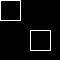

0


In [214]:
box_a = [0, 20, 0, 20]
box_b = [30, 50, 30, 50]
im = np.zeros((60, 60))
im = cv.rectangle(im, (box_a[0], box_a[2]), (box_a[1], box_a[3]), 255, 1)
im = cv.rectangle(im, (box_b[0], box_b[2]), (box_b[1], box_b[3]), 255, 1)
imshow(im)
overlapp = compute_overlapp(box_a, box_b)
print(overlapp)


In [243]:
784+196+49+16+1

1046